# Классификация заемщиков 

## Студент: Нафикова Лиана

1. Выбор данных и метрики

    ○ Выберите набор данных для задачи классификации.
    Эксперименты будем проводить на [датасете](https://www.kaggle.com/competitions/home-credit-default-risk/overview) по классификации заемщиков на плохих (target = 1: клиент с "payment difficulties") и хороших (target = 0: все остальные). Для экспериментов будем использовать лишь основной файл `application_train.csv`, а также перекодируем таргет в метки -1, 1.
    
    ○ Обоснуйте выбор целевой функции.
    Так как в данных нет сильного дисбаланса(люди делают всё-таки заказы достаточно часто), была выбрана эта метрика + она не зависит от выбранного порога + довольно интерпретируемая.


2. Алгоритмы и пространство гиперпараметров
○ Выберите не менее двух алгоритмов обучения с учителем (например, KNN,
Random Forest, XGBoost):

Выбрала логистическую регрессию и LightGBM

○ Опишите гиперпараметры и границы поиска.

Для логистической регрессии перебираем солверы, коэффициент регуляризации и число итераций

'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

'C' : 1e-4 - 1e2

'max_iter': 50 - 1000

Для бустинга максимальное число в листе, learning rate, глубину дерева

'max_leaves': 16, 256

'eta', 0.01, 0.1

'max_depth': 4 - 8

"n_estimators":  50, 1000

3. Оптимизация

    ○ Запустите процесс настройки гиперпараметров с помощью одной из
библиотек Optuna или Hyperopt.

    ○ Визуализируйте зависимость целевой функции от числа итераций.


    ○ Сравните результаты со случайным поиском.

    ○ Сравните с одним из инструментов для выбора алгоритма и оптимизации
гиперпараметров (например, auto-sklearn, AutoGluon, TPOT, LightAutoML,
FEDOT или иным).

In [ ]:
!pip install optuna

In [3]:
import time
from functools import partial

import numpy as np
np.random.seed(42)

import pandas as pd
pd.options.display.max_columns = 100
pd.options.display.max_rows = 150

from scipy.special import expit

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score

import optuna

c:\Users\Лиана\OneDrive\Desktop\ITMO\AutoML-ITMO\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Подготовка данных

In [4]:
data = pd.read_csv('application_train.csv')
data.columns = [
    '_'.join([word.lower() for word in col_name.split(' ') if word != '-']) for col_name in data.columns
]
data.target = data.target.map({0: -1, 1: 1})
data.head(3)

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,occupation_type,cnt_fam_members,region_rating_client,region_rating_client_w_city,weekday_appr_process_start,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,organization_type,ext_source_1,ext_source_2,ext_source_3,apartments_avg,basementarea_avg,years_beginexpluatation_avg,years_build_avg,commonarea_avg,elevators_avg,...,apartments_medi,basementarea_medi,years_beginexpluatation_medi,years_build_medi,commonarea_medi,elevators_medi,entrances_medi,floorsmax_medi,floorsmin_medi,landarea_medi,livingapartments_medi,livingarea_medi,nonlivingapartments_medi,nonlivingarea_medi,fondkapremont_mode,housetype_mode,totalarea_mode,wallsmaterial_mode,emergencystate_mode,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,...,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,-1,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,...,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,-1,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
test_idx = data.sk_id_curr % 10 >= 7
data_dict = dict()
data_dict['tst'] = data.loc[test_idx].reset_index(drop=True)
data_dict['tr'] = data.loc[~test_idx].reset_index(drop=True)

for key, df in data_dict.items():
    print(key, 'shape:', df.shape)

tst shape: (92221, 122)
tr shape: (215290, 122)


In [6]:
features = data.select_dtypes(np.number).drop(columns=['target', 'sk_id_curr']).columns

X_tr, X_tst = data_dict["tr"][features].to_numpy(), data_dict["tst"][features].to_numpy()
y_tr, y_tst = data_dict["tr"]["target"].to_numpy(), data_dict["tst"]["target"].to_numpy()

prep = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

prep.fit(X_tr)

X_tr = prep.transform(X_tr)
X_tst = prep.transform(X_tst)

### Логистическая регрессия оптуна

In [ ]:
def objective(
    trial: optuna.trial.Trial,
    X_tr, X_val, y_tr, y_val
):
    solver =  trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'])
    C = trial.suggest_float('C', 1e-4, 1e2)
    max_iter = trial.suggest_int('max_iter', 50, 1000, log=True)

    start_time = time.time()
    model = LogisticRegression(solver=solver, penalty='l2', C=C, max_iter=max_iter, random_state=42)
    model.fit(X_tr, y_tr)
    train_time = time.time() - start_time

    y_pred_proba = model.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_pred_proba)

    trial.set_user_attr('train_time', train_time)
    return score

In [ ]:
study = optuna.create_study(direction='maximize')
obj_func = partial(objective, X_tr=X_tr, X_val=X_tst, y_tr=y_tr, y_val=y_tst)
study.optimize(obj_func, n_trials=50, n_jobs=-1, gc_after_trial=True)

[I 2025-09-13 13:53:08,419] A new study created in memory with name: no-name-877e649f-c031-4b8a-b99c-ef52f2f41e41
[I 2025-09-13 13:53:27,005] Trial 4 finished with value: 0.7352816312716332 and parameters: {'solver': 'lbfgs', 'C': 71.67820657786409, 'max_iter': 306}. Best is trial 4 with value: 0.7352816312716332.
[I 2025-09-13 13:53:30,458] Trial 0 finished with value: 0.7352816517933147 and parameters: {'solver': 'lbfgs', 'C': 79.9656603379841, 'max_iter': 134}. Best is trial 0 with value: 0.7352816517933147.
[I 2025-09-13 13:53:32,059] Trial 2 finished with value: 0.7352542379837859 and parameters: {'solver': 'lbfgs', 'C': 3.0718717060892113, 'max_iter': 762}. Best is trial 0 with value: 0.7352816517933147.
[I 2025-09-13 13:53:38,956] Trial 12 finished with value: 0.7352817528231322 and parameters: {'solver': 'lbfgs', 'C': 47.690707711092585, 'max_iter': 231}. Best is trial 12 with value: 0.7352817528231322.
[I 2025-09-13 13:54:00,613] Trial 9 finished with value: 0.7380056129956548

In [ ]:
from optuna.visualization import plot_optimization_history, plot_param_importances

plot_optimization_history(study).show()

plot_param_importances(study).show()

### Логистическая регрессия random search

In [ ]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression


model = LogisticRegression()

param_dist = {
    "solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    "C": np.logspace(-4, 2, 50),
    "max_iter": np.logspace(np.log10(50), np.log10(1000), 20, dtype=int)
}

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=30,
    scoring="roc_auc",
    cv=2,
    random_state=42,
    n_jobs=-1,
    verbose=3
)

random_search.fit(X_tr, y_tr)

print(f"Лучшие параметры: {random_search.best_params_}")

Fitting 2 folds for each of 30 candidates, totalling 60 fits
Лучшие параметры: {'solver': 'newton-cg', 'max_iter': np.int64(283), 'C': np.float64(32.3745754281764)}


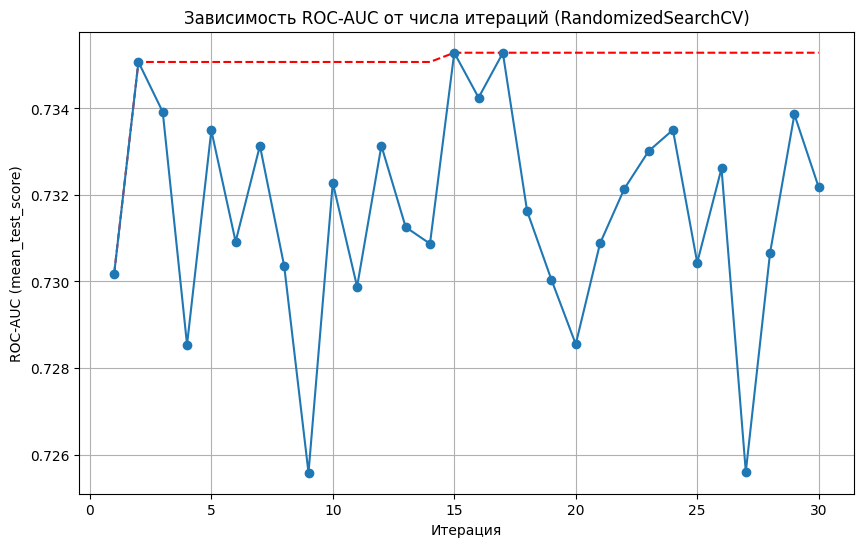

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

results = pd.DataFrame(random_search.cv_results_)
mean_scores = results["mean_test_score"]
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(mean_scores) + 1), np.maximum.accumulate(mean_scores),
         linestyle="--", color="red", label="Best so far")
plt.plot(range(1, len(results) + 1), results["mean_test_score"], marker="o")
plt.xlabel("Итерация")
plt.ylabel("ROC-AUC (mean_test_score)")
plt.title("Зависимость ROC-AUC от числа итераций (RandomizedSearchCV)")
plt.grid(True)
plt.show()

# Градиентный бустинг оптуна

In [ ]:
!pip install lightgbm

In [ ]:
import time
import optuna
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

def boost_objective(
    trial: optuna.trial.Trial,
    X_tr, X_val, y_tr, y_val
):
    params = {
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "num_leaves": trial.suggest_int("num_leaves", 16, 256, log=True),
        "max_depth": trial.suggest_int("max_depth", 4, 8, log=True),
        "eta": trial.suggest_float("eta", 1e-3, 0.1, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000, log=True),
        "random_state": 42,
        "n_jobs": -1,
    }

    start_time = time.time()
    
    model = lgb.LGBMClassifier(**params)
    model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], eval_metric="auc")
    train_time = time.time() - start_time

    y_pred_proba = model.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_pred_proba)

    trial.set_user_attr("train_time", train_time)
    return score

In [ ]:
boost_study = optuna.create_study(direction='maximize')
boost_obj_func = partial(boost_objective, X_tr=X_tr, X_val=X_tst, y_tr=y_tr, y_val=y_tst)
boost_study.optimize(boost_obj_func, n_trials=50, n_jobs=-1, gc_after_trial=True)

[I 2025-09-13 14:19:14,482] A new study created in memory with name: no-name-7d23c4ac-c5e0-4b92-a080-56fff27976c9
c:\Users\Лиана\OneDrive\Desktop\ITMO\AutoML-ITMO\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

[I 2025-09-13 14:19:44,673] Trial 11 finished with value: 0.7517922239717396 and parameters: {'num_leaves': 17, 'max_depth': 7, 'eta': 0.025455180385235896, 'n_estimators': 129}. Best is trial 11 with value: 0.7517922239717396.
c:\Users\Лиана\OneDrive\Desktop\ITMO\AutoML-ITMO\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

[I 2025-09-13 14:19:47,641] Trial 4 finished with value: 0.7499309974239765 and parameters: {'num_leaves': 37, 'max_depth': 6, 'eta': 0.0060298969988305355, 'n_estimators': 68}. Best is trial 11 with value: 0.7517922239717396.
c:\Users\Лиана\

In [ ]:
from optuna.visualization import plot_optimization_history, plot_param_importances

plot_optimization_history(boost_study).show()

plot_param_importances(boost_study).show()

### Градиентный бустинг random search

In [ ]:
lgbm = lgb.LGBMClassifier(
    objective="binary",
    metric="auc",
    verbosity=-1,
    random_state=42,
    n_jobs=-1
)

param_dist = {
    "num_leaves": np.arange(16, 257, 16),
    "max_depth": np.arange(4, 9, 1),
    "eta": np.logspace(-3, -1, 50), 
    "n_estimators": np.arange(50, 1001, 50),
}

boost_random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=50,          
    scoring="roc_auc",  
    random_state=42,
    cv=2,
    n_jobs=-1,
    verbose=3
)

boost_random_search.fit(X_tr, y_tr)

print("RandomSearchCV best ROC-AUC:", boost_random_search.best_score_)
print("Best params:", boost_random_search.best_params_)

Fitting 2 folds for each of 50 candidates, totalling 100 fits
RandomSearchCV best ROC-AUC: 0.745935607069822
Best params: {'num_leaves': np.int64(176), 'n_estimators': np.int64(200), 'max_depth': np.int64(4), 'eta': np.float64(0.004498432668969444)}


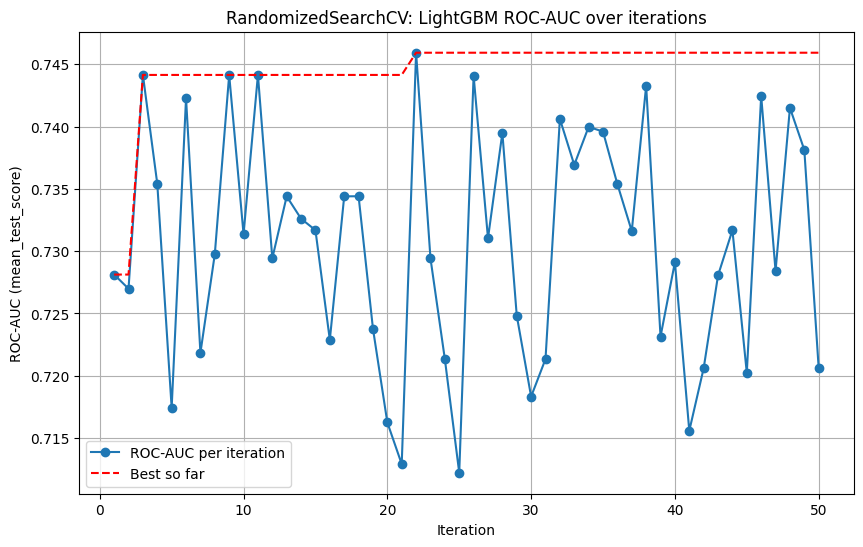

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

results = pd.DataFrame(boost_random_search.cv_results_)
mean_scores = results["mean_test_score"]

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(mean_scores) + 1), mean_scores, marker="o", label="ROC-AUC per iteration")
plt.plot(range(1, len(mean_scores) + 1), np.maximum.accumulate(mean_scores),
         linestyle="--", color="red", label="Best so far")
plt.xlabel("Iteration")
plt.ylabel("ROC-AUC (mean_test_score)")
plt.title("RandomizedSearchCV: LightGBM ROC-AUC over iterations")
plt.legend()
plt.grid(True)
plt.show()

### lightautoml

In [ ]:
!pip install -U lightautoml

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

In [ ]:
task = Task('binary')

In [ ]:
roles = {
    'target': 'target'
}

In [ ]:
automl = TabularAutoML(
    task = task,
    timeout = 600,
    cpu_limit = -1,
    reader_params = {'cv': 2, 'random_state': 42},
)

In [ ]:
import pandas as pd

feature_names = [f"f{i}" for i in range(X_tr.shape[1])]

train_data = pd.DataFrame(X_tr, columns=feature_names)
train_data["target"] = y_tr  

test_data = pd.DataFrame(X_tst, columns=feature_names)
test_data["target"] = y_tst
train_data

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,...,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,f100,f101,f102,f103,target
0,-0.578022,0.319572,-0.478530,-0.166611,-0.507693,-0.148956,1.507080,-0.456725,0.378344,0.579037,-0.146714,0.002155,0.469198,-0.499427,0.042491,1.596250,-0.24635,-1.268051,-0.103730,-0.062977,-0.631105,-0.125246,-0.231333,-0.20509,-0.292269,-0.547097,-0.466809,-3.019282,-1.317838,-2.151710,-1.001929,-0.840529,-0.173447,-2.063457,-0.321108,-0.368122,-1.062255,-1.060530,-0.984358,-0.354417,-1.185346,-0.901696,-0.100543,-0.307868,-0.955134,-0.770708,-0.151662,-2.027627,-0.277881,-0.355786,...,-0.864580,-0.09533,-0.262327,-0.984777,-0.834923,-0.171482,-2.058413,-0.313138,-0.364988,-1.055607,-1.056321,-0.980393,-0.352276,-1.178089,-0.894608,-0.099534,-0.297948,-0.900454,0.240361,4.122506,0.249629,5.229995,-0.207918,-0.006816,0.638452,-0.009395,-0.124305,-0.310248,-0.013111,-0.297036,-0.06206,-0.004819,-0.063033,-0.003048,-0.058209,-0.05469,-0.034839,-0.100506,-0.016416,-0.090632,-0.023909,-0.023118,-0.018915,-0.071300,-0.059013,-0.157032,-0.270450,-0.285845,-0.440061,1
1,-0.578022,0.954819,1.722912,0.590166,1.597702,-1.252328,-0.165117,-0.460622,1.076840,1.790664,-0.146714,0.002155,0.469198,-0.499427,0.042491,1.596250,-0.24635,-0.167174,-2.065944,-2.050710,-0.325269,-0.125246,-0.231333,-0.20509,-0.292269,-0.547097,-0.466809,-1.383890,0.564738,0.112206,-0.080506,-0.538185,0.129147,0.637912,0.746047,0.431974,-1.553364,0.890144,1.271189,-0.811252,-0.116553,-0.450692,0.046638,-0.101032,-0.083506,-0.484326,0.125819,0.643956,0.555349,0.469789,...,-0.422156,-0.09533,-0.262327,-0.064388,-0.531609,0.127440,0.635809,0.756303,0.437123,-1.545333,0.889906,1.268098,-0.811606,-0.102462,-0.443130,0.049085,-0.088993,-0.186267,-0.171460,-0.319130,-0.165885,-0.274455,0.162697,-0.006816,0.638452,-0.009395,-0.124305,-0.310248,-0.013111,-0.297036,-0.06206,-0.004819,-0.063033,-0.003048,-0.058209,-0.05469,-0.034839,-0.100506,-0.016416,-0.090632,-0.023909,-0.023118,-0.018915,-0.071300,-0.059013,-0.157032,-0.270450,-0.285845,-1.005020,-1
2,-0.578022,-0.950920,-1.152679,-1.401792,-1.091849,-0.782998,-0.687335,-0.453810,0.204713,0.306768,2.246771,0.002155,0.469198,2.002296,0.042491,1.596250,-0.24635,-1.268051,-0.103730,-0.062977,-0.936940,-0.125246,-0.231333,-0.20509,-0.292269,-0.547097,-0.466809,0.010857,0.217176,1.223236,-0.190507,-0.094117,0.047047,0.014520,-0.164038,-0.368122,-0.081460,-0.279886,-0.082356,-0.140335,-0.148373,-0.205717,-0.100543,-0.231887,-0.192460,-0.098173,0.050533,0.027557,-0.166941,-0.355786,...,-0.203429,-0.09533,-0.239441,-0.197704,-0.093698,0.046337,0.014779,-0.165629,-0.364988,-0.077576,-0.277457,-0.081212,-0.140569,-0.150514,-0.206877,-0.099534,-0.233172,-0.220397,-0.583281,-0.319130,-0.581400,-0.274455,0.178442,-0.006816,-1.566288,-0.009395,-0.124305,-0.310248,-0.013111,-0.297036,-0.06206,-0.004819,-0.063033,-0.003048,-0.058209,-0.05469,-0.034839,-0.100506,-0.016416,-0.090632,-0.023909,-0.023118,-0.018915,-0.071300,-0.059013,-0.157032,-0.270450,-0.285845,-1.005020,-1
3,-0.578022,-0.315674,-0.711642,0.176478,-0.653732,-0.928547,-0.677949,-0.473715,-1.376408,0.369039,-0.146714,0.002155,0.469198,-0.499427,0.042491,-0.626468,-0.24635,-0.167174,-0.103730,-0.062977,1.509745,-0.125246,-0.231333,-0.20509,-0.292269,-0.547097,-0.466809,0.010857,0.712474,0.112206,-0.190507,-0.094117,0.047047,0.014520,-0.164038,-0.368122,-0.081460,-0.279886,-0.082356,-0.140335,-0.148373,-0.205717,-0.100543,-0.231887,-0.192460,-0.098173,0.050533,0.027557,-0.166941,-0.355786,...,-0.203429,-0.09533,-0.239441,-0.197704,-0.093698,0.046337,0.014779,-0.165629,-0.364988,-0.077576,-0.277457,-0.081212,-0.140569,-0.150514,-0.206877,-0.099534,-0.233172,-0.220397,0.240361,-0.

In [ ]:
out_of_fold_predictions = automl.fit_predict(train_data, roles = roles, verbose = 1)

[17:28:59] Stdout logging level is INFO.
[17:28:59] Task: binary

[17:28:59] Start automl preset with listed constraints:
[17:28:59] - time: 600.00 seconds
[17:28:59] - CPU: 12 cores
[17:28:59] - memory: 16 GB

[17:28:59] Train data shape: (215290, 105)

[17:29:22] Layer 1 train process start. Time left 577.41 secs
[17:29:41] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[17:30:06] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.7420675451385583
[17:30:06] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[17:30:06] Time left 533.06 secs

[17:30:17] Selector_LightGBM fitting and predicting completed
[17:30:34] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[17:30:55] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.7463272736564132
[17:30:55] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[17:30:55] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 40.83 secs


Optimization Progress:   4%|▍         | 4/101 [00:42<17:03, 10.55s/it, best_trial=3, best_value=0.747]

[17:31:37] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[17:31:37] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


[17:31:51] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.7462353028702844
[17:31:51] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[17:31:51] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[17:32:31] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.7486201074234646
[17:32:31] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[17:32:31] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 155.35 secs


Optimization Progress:   8%|▊         | 8/101 [02:38<30:45, 19.84s/it, best_trial=2, best_value=0.751]

[17:35:10] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[17:35:10] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


[17:36:43] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = 0.7519813437192711
[17:36:43] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
[17:36:43] Time left 135.98 secs

[17:36:43] Layer 1 training completed.

[17:36:43] Blending: optimization starts with equal weights. Score = 0.7523758
[17:36:46] Blending: iteration 0: score = 0.7528301, weights = [0.11165655 0.16543774 0.07877672 0.11570287 0.5284262 ]
[17:36:49] Blending: iteration 1: score = 0.7528580, weights = [0.08358003 0.19752733 0.08302417 0.06603661 0.56983185]
[17:36:52] Blending: iteration 2: score = 0.7528582, weights = [0.08523156 0.19600758 0.08578999 0.05796957 0.5750013 ]
[17:36:55] Blending: iteration 3: score = 0.7528586, weights = [0.08862109 0.19383161 0.08159935 0.07377811 0.56216985]
[17:36:57] Blending: no improvements for score. Terminated.

[17:36:57] Blending: best score = 0.7528586, best weights = [0.08862109 0.19383161 0.08159935 0.07377811 0.56216985]
[17:36:57] Automl pre

In [ ]:
%%time
test_predictions = automl.predict(test_data)
print(f'Prediction for test_data:\n{test_predictions}\nShape = {test_predictions.shape}')

Prediction for test_data:
array([[0.105547  ],
       [0.0492829 ],
       [0.01797524],
       ...,
       [0.11997726],
       [0.06642464],
       [0.02882528]], dtype=float32)
Shape = (92221, 1)
CPU times: total: 21.4 s
Wall time: 9.03 s


In [ ]:
print(f'OOF score: {roc_auc_score(train_data['target'].values, out_of_fold_predictions.data[:, 0])}')

OOF score: 0.7528586140416317


## 4. Анализ поведения оптимизаторов

### 4.1. Скорость сходимости

•   **Random Search:** Сходимость происходит довольно быстро на первых итерациях, затем наблюдается стабилизация с небольшими колебаниями.
•   **Optuna:** Скорость сходимости хорошая, но требует больше итераций, чем Random Search, для достижения лучших результатов. На графике истории оптимизации видно, как постепенно улучшается значение целевой функции. Параметры подбираются в окрестности лучших
•   **AutoML:**  LightAutoML показывает очень быструю сходимость на этапе обучения

### 4.2. Переобучение

•   **Random Search:** Небольшое переобучение возможно, но сложно оценить точно
•   **Optuna:** Также сложно оценить переобучение без отдельной тестовой выборки, но Optuna предоставляет возможность мониторинга OOF-score, что помогает выявлять эту проблему.
•   **AutoML:** LightAutoML может показывать некоторое переобучение, т.к. OOF score на обучающей выборке может несколько отличаться от результатов на тестовой выборке. Это связано со спецификой работы алгоритма и необходимостью валидации.

### 4.3. Разброс результатов

•   **Random Search:** сильный разброс потому что выбирается рандомно
•   **Optuna:** Более стабильные результаты, чем Random Search, благодаря использованию TPE sampler, который учитывает прошлые результаты для выбора новых гиперпараметров.
•   **AutoML:** Результаты примерно такие же хорошие как и с оптуной

### 4.4. Объяснение различий в поведении

•   **Random Search:** Просто случайный поиск в заданном пространстве. Не использует информацию о предыдущих итерациях.
•   **Optuna:** Использует TPE sampler (Tree-structured Parzen Estimator), который строит вероятностные модели для оценки перспективных гиперпараметров на основе прошлых результатов. Это позволяет более эффективно исследовать пространство поиска и находить лучшие решения.
•   **AutoML:** Автоматически подбирает наиболее подходящий алгоритм и настраивает его гиперпараметры. Использует сложную стратегию, включающую различные методы оптимизации и оценки качества моделей.

### Градиентный бустинг с другой метрикой

In [16]:
from sklearn.metrics import f1_score

def boost_objective_f1(
    trial: optuna.trial.Trial,
    X_tr, X_val, y_tr, y_val
):
    params = {
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "num_leaves": trial.suggest_int("num_leaves", 16, 256, log=True),
        "max_depth": trial.suggest_int("max_depth", 4, 8, log=True),
        "eta": trial.suggest_float("eta", 1e-3, 0.1, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000, log=True),
        "random_state": 42,
        "n_jobs": -1,
    }
    
    model = lgb.LGBMClassifier(**params)
    model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], eval_metric="auc")

    y_pred_proba = model.predict(X_val)
    score = f1_score(y_val, y_pred_proba)
    return score

In [17]:
from functools import partial

study_f1 = optuna.create_study(direction='maximize')
obj_func_f1 = partial(boost_objective_f1, X_tr=X_tr, X_val=X_tst, y_tr=y_tr, y_val=y_tst)
study_f1.optimize(obj_func_f1, n_trials=50, n_jobs=-1, gc_after_trial=True)

print("Best F1-score:", study_f1.best_value)
print("Best parameters:", study_f1.best_params)

[I 2025-09-13 18:35:52,727] A new study created in memory with name: no-name-d28d6e70-cf62-4cc9-8e7b-64fff1d244c1
c:\Users\Лиана\OneDrive\Desktop\ITMO\AutoML-ITMO\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-13 18:36:30,924] Trial 6 finished with value: 0.022084921782568687 and parameters: {'num_leaves': 234, 'max_depth': 5, 'eta': 0.001171932250687387, 'n_estimators': 72}. Best is trial 6 with value: 0.022084921782568687.
c:\Users\Лиана\OneDrive\Desktop\ITMO\AutoML-ITMO\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-09-13 18:36:36,612] Trial 1 finished with value: 0.031237797735259663 and parameters: {'num_leaves': 140, 'max_depth': 4, 'eta': 0.0024327870438355524, 'n_estimators': 149}. Best is trial 1 with value: 

Best F1-score: 0.07304133251079581
Best parameters: {'num_leaves': 168, 'max_depth': 8, 'eta': 0.036262094263259076, 'n_estimators': 898}


In [18]:
from optuna.visualization import plot_optimization_history, plot_param_importances

plot_optimization_history(study_f1).show()

plot_param_importances(study_f1).show()

In [20]:
study_f1.best_params

{'num_leaves': 168,
 'max_depth': 8,
 'eta': 0.036262094263259076,
 'n_estimators': 898}

### 5.1. Сравнение результатов с ROC-AUC

Сравним результаты, полученные с использованием F1-меры, с результатами, полученными с ROC-AUC.

•   **Изменился ли выбор гиперпараметров?**  
•   **С чем это связано?**

F1-мера более чувствительна к балансу классов. Если у нас классы сбалансированы, то выбор гиперпараметров может не сильно отличаться. Однако, если есть заметный дисбаланс, то F1-мера может привести к выбору других гиперпараметров, которые лучше оптимизируют точность и полноту для миноритарного класса.  Solver может быть более склонным к liblinear, так как он хорошо работает с L1 регуляризацией, которая может помочь в отборе признаков и борьбе с переобучением.  C и max_iter могут измениться в зависимости от того, насколько сильно модель штрафуется за ошибки в миноритарном классе.

### Фиктивные переменные 

In [30]:
X_tr_fake = X_tr.copy()
X_val_fake = X_tst.copy()

# добавляем фиктивные признаки
for i in range(5):
    X_tr_fake = np.hstack([X_tr_fake, np.random.rand(X_tr.shape[0], 1)])
    X_val_fake = np.hstack([X_val_fake, np.random.rand(X_tst.shape[0], 1)])

In [33]:
import lightgbm as lgb
from sklearn.metrics import f1_score
import numpy as np

def boost_objective_f1(trial, X_tr, X_val, y_tr, y_val, n_fake_features=0):
    X_tr_mod = X_tr.copy()
    X_val_mod = X_val.copy()
    
    for i in range(n_fake_features):
        X_tr_mod = np.hstack([X_tr_mod, np.random.rand(X_tr.shape[0], 1)])
        X_val_mod = np.hstack([X_val_mod, np.random.rand(X_val.shape[0], 1)])
    
    params = {
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "num_leaves": trial.suggest_int("num_leaves", 16, 256, log=True),
        "max_depth": trial.suggest_int("max_depth", 4, 8, log=True),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000, log=True),
        "random_state": 42,
        "n_jobs": -1,
    }
    
    model = lgb.LGBMClassifier(**params)
    model.fit(X_tr_mod, y_tr, eval_set=[(X_val_mod, y_val)], eval_metric="auc")
    
    y_pred_proba = model.predict_proba(X_val_mod)[:, 1]
    score = roc_auc_score(y_val, y_pred_proba)

    return score


In [35]:
import optuna

fake_study = optuna.create_study(direction="maximize")
fake_study.optimize(lambda trial: boost_objective_f1(trial, X_tr, X_tst, y_tr, y_tst, n_fake_features=5), timeout=300)

print("Best roc_auc:", fake_study.best_value)
print("Best params:", fake_study.best_params)

[I 2025-09-13 19:50:37,970] A new study created in memory with name: no-name-82684e6b-9676-4457-bea0-988fd2eeeca5
c:\Users\Лиана\OneDrive\Desktop\ITMO\AutoML-ITMO\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

[I 2025-09-13 19:51:14,648] Trial 0 finished with value: 0.7487543031401251 and parameters: {'num_leaves': 122, 'max_depth': 6, 'learning_rate': 0.05247969511760212, 'n_estimators': 750}. Best is trial 0 with value: 0.7487543031401251.
c:\Users\Лиана\OneDrive\Desktop\ITMO\AutoML-ITMO\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

[I 2025-09-13 19:51:27,347] Trial 1 finished with value: 0.72525166014485 and parameters: {'num_leaves': 100, 'max_depth': 5, 'learning_rate': 0.0036933197426018555, 'n_estimators': 265}. Best is trial 0 with value: 0.7487543031401251

Best roc_auc: 0.7534127233005621
Best params: {'num_leaves': 72, 'max_depth': 4, 'learning_rate': 0.06347718810669867, 'n_estimators': 575}


In [36]:
from optuna.visualization import plot_optimization_history, plot_param_importances

plot_optimization_history(fake_study).show()

plot_param_importances(fake_study).show()

Включение фиктивных переменных, которые не влияют на целевую функцию, немного замедляет сходимость. Качество при этом пострадало несильно, я считаю, что это связано с выбором модели. Лог рег скорее всего повёл бы себя хуже

широкие диапозоны

In [38]:
def boost_objective_wide(trial, X_tr, X_val, y_tr, y_val):
    params = {
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "num_leaves": trial.suggest_int("num_leaves", 2, 1024, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 20),
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 0.5, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 10, 5000, log=True),
        "random_state": 42,
        "n_jobs": -1
    }
    
    model = lgb.LGBMClassifier(**params)
    model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], eval_metric="auc")
    
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, y_pred_proba)

study_wide = optuna.create_study(direction="maximize")
study_wide.optimize(lambda trial: boost_objective_wide(trial, X_tr, X_tst, y_tr, y_tst), timeout=300)


[I 2025-09-13 19:58:59,469] A new study created in memory with name: no-name-c842983c-c222-486b-8218-0f697b54e5ce
c:\Users\Лиана\OneDrive\Desktop\ITMO\AutoML-ITMO\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

[I 2025-09-13 19:59:49,470] Trial 0 finished with value: 0.7083856532292011 and parameters: {'num_leaves': 380, 'max_depth': 10, 'learning_rate': 1.1140118016823712e-05, 'n_estimators': 344}. Best is trial 0 with value: 0.7083856532292011.
c:\Users\Лиана\OneDrive\Desktop\ITMO\AutoML-ITMO\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

[I 2025-09-13 19:59:54,607] Trial 1 finished with value: 0.7292261044946666 and parameters: {'num_leaves': 38, 'max_depth': 17, 'learning_rate': 0.017438623636572243, 'n_estimators': 53}. Best is trial 1 with value: 0.729226104494

In [39]:
from optuna.visualization import plot_optimization_history, plot_param_importances

plot_optimization_history(study_wide).show()

plot_param_importances(study_wide).show()

С одной стороны, это позволяет найти более оптимальные значения, выходящие за пределы исходного пространства поиска. С другой стороны, широкие диапазоны увеличивают пространство поиска, что затрудняет сходимость и требует большего количества итераций для достижения оптимального результата. Качество чуть хуже

Узкое пространство поиска

In [40]:
def boost_objective_narrow(trial, X_tr, X_val, y_tr, y_val):
    params = {
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "num_leaves": trial.suggest_int("num_leaves", 100, 150),
        "max_depth": trial.suggest_int("max_depth", 5, 7),
        "learning_rate": trial.suggest_float("learning_rate", 0.04, 0.06),
        "n_estimators": trial.suggest_int("n_estimators", 400, 600),
        "random_state": 42,
        "n_jobs": -1
    }
    
    model = lgb.LGBMClassifier(**params)
    model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], eval_metric="auc")
    
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, y_pred_proba)

study_narrow = optuna.create_study(direction="maximize")
study_narrow.optimize(lambda trial: boost_objective_narrow(trial, X_tr, X_tst, y_tr, y_tst), timeout=300)

[I 2025-09-13 20:04:20,416] A new study created in memory with name: no-name-19e51b44-5cca-4b17-bf63-c46f3ab45a6b
c:\Users\Лиана\OneDrive\Desktop\ITMO\AutoML-ITMO\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

[I 2025-09-13 20:04:50,173] Trial 0 finished with value: 0.7503553210786795 and parameters: {'num_leaves': 138, 'max_depth': 7, 'learning_rate': 0.04345147698056732, 'n_estimators': 580}. Best is trial 0 with value: 0.7503553210786795.
c:\Users\Лиана\OneDrive\Desktop\ITMO\AutoML-ITMO\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

[I 2025-09-13 20:05:15,527] Trial 1 finished with value: 0.7489454231401063 and parameters: {'num_leaves': 144, 'max_depth': 7, 'learning_rate': 0.05095238224429107, 'n_estimators': 580}. Best is trial 0 with value: 0.7503553210786795

In [41]:
from optuna.visualization import plot_optimization_history, plot_param_importances

plot_optimization_history(study_narrow).show()

plot_param_importances(study_narrow).show()

Качество чуть хуже, но при этом конкретная область исследуется лучше, качество стабильно растёт от итерации к итерации

разное число параметров

In [42]:
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import lightgbm as lgb


def logreg_objective(trial, X_tr, X_val, y_tr, y_val):
    solver = trial.suggest_categorical("solver", ["newton-cg", "lbfgs", "liblinear", "sag", "saga"])
    C = trial.suggest_float("C", 1e-4, 100, log=True)
    max_iter = trial.suggest_int("max_iter", 50, 1000)
    
    model = LogisticRegression(solver=solver, C=C, max_iter=max_iter, random_state=42)
    model.fit(X_tr, y_tr)
    
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, y_pred_proba)

In [43]:
def lgb_objective(trial, X_tr, X_val, y_tr, y_val):
    params = {
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "num_leaves": trial.suggest_int("num_leaves", 16, 256, log=True),
        "max_depth": trial.suggest_int("max_depth", 4, 12),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000, log=True),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "random_state": 42,
        "n_jobs": -1
    }
    
    model = lgb.LGBMClassifier(**params)
    model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], eval_metric="auc")
    
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, y_pred_proba)

In [44]:
study_lr = optuna.create_study(direction="maximize")
study_lr.optimize(lambda trial: logreg_objective(trial, X_tr, X_tst, y_tr, y_tst), timeout=300)

[I 2025-09-13 20:09:34,591] A new study created in memory with name: no-name-b910488b-3297-4f15-9072-4c9004b63f20
[I 2025-09-13 20:09:41,789] Trial 0 finished with value: 0.7354161209017511 and parameters: {'solver': 'newton-cg', 'C': 0.03938732528348374, 'max_iter': 496}. Best is trial 0 with value: 0.7354161209017511.
c:\Users\Лиана\OneDrive\Desktop\ITMO\AutoML-ITMO\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

[I 2025-09-13 20:13:14,226] Trial 1 finished with value: 0.7349961809939709 and parameters: {'solver': 'saga', 'C': 0.19853691461576983, 'max_iter': 533}. Best is trial 0 with value: 0.7354161209017511.
[I 2025-09-13 20:13:44,532] Trial 2 finished with value: 0.7380310472521981 and parameters: {'solver': 'newton-cg', 'C': 69.14509761234169, 'max_iter': 622}. Best is trial 2 with value: 0.7380310472521981.
c:\Users\Лиана\OneDrive\Desktop\ITMO\AutoML-ITMO\.venv\Lib\site-packages\skl

In [47]:
from optuna.visualization import plot_optimization_history, plot_param_importances

plot_optimization_history(study_lr).show()

plot_param_importances(study_lr).show()

Очень медленная скорость сходимости и низкое качество из-за этого

In [45]:
study_lgb = optuna.create_study(direction="maximize")
study_lgb.optimize(lambda trial: lgb_objective(trial, X_tr, X_tst, y_tr, y_tst), timeout=300)

[I 2025-09-13 20:17:12,452] A new study created in memory with name: no-name-597675fb-90bc-4932-a833-5607a510b69e
c:\Users\Лиана\OneDrive\Desktop\ITMO\AutoML-ITMO\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

[I 2025-09-13 20:17:16,179] Trial 0 finished with value: 0.7293032999574491 and parameters: {'num_leaves': 156, 'max_depth': 5, 'learning_rate': 0.0048283711914678795, 'n_estimators': 58, 'min_child_samples': 21, 'subsample': 0.7648025809477998, 'colsample_bytree': 0.6363286499473447}. Best is trial 0 with value: 0.7293032999574491.
c:\Users\Лиана\OneDrive\Desktop\ITMO\AutoML-ITMO\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

[I 2025-09-13 20:17:21,837] Trial 1 finished with value: 0.7352396533824822 and parameters: {'num_leaves': 18, 'max_depth': 8, 'learnin

In [46]:
from optuna.visualization import plot_optimization_history, plot_param_importances

plot_optimization_history(study_lgb).show()

plot_param_importances(study_lgb).show()